# Plate

In [1]:
import numpy as np
from hedgehog.plate import *

import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%aimport hedgehog.plate
%autoreload 1

### The System

In [2]:
'''
w = [[w1], [w2], [w3], [w4], [w5]]
'''

def w_1_prime(eta, w):
    w2 = w[1][0]
    return w2

def w_2_prime(eta, w):
    w3 = w[2][0]
    return w3

def w_3_prime(eta, w):
    w1 = w[0][0]
    w3 = w[2][0]
    ans = -0.5 * w1 * w3
    return ans

def w_4_prime(eta, w):
    w5 = w[4][0]
    return w5

def w_5_prime(eta, w):
    w1 = w[0][0]
    w5 = w[4][0]
    y = -Pr/2 * w1 * w5
    return y

### Guessing Initial values
#### Just $F$

In [49]:
def get_w2_init(tf, tol=10e-8, isVerbose=False):
    # boundary value for w2
    beta = 1

    # guesses to straddle the root
    a = 0
    b = 1

    # tolerance in the boundary value
    err = tol * 10

    # how much do we want to integrate
    t0 = 0.0

    # system
    system = np.array([[w_1_prime], [w_2_prime], [w_3_prime]])

    # continue bisecting while err > tolerance
    while err > tol:

        # boundary value with initial condition as a
        w_0 = np.array([[0.0], [0.0], [a]])
        h = 0.1
        w_a, W, T = runge_kutta_4(system, w_0, h, t0, tf, isVerbose=False, retAll=True)

        # boundary valye with initial condition as b
        w_0 = np.array([[0.0], [0.0], [b]])
        h = 0.1
        w_b, W, T = runge_kutta_4(system, w_0, h, t0, tf, isVerbose=False, retAll=True)

        # how far are the boundary values with each initial guess
        diff_a = np.abs(beta - w_a[1][0])
        diff_b = np.abs(beta - w_b[1][0])

        # perform bisection
        # replace worse guess with the middle point
        c = (a+b) / 2
        if diff_a > diff_b:
            a = c
            err = diff_b
        else:
            b = c
            err = diff_a
    
    if isVerbose:
        print(a, b)
        print(w_a[1][0], w_b[1][0])

    w_2_init = (a + b) / 2
    if isVerbose:
        print(w_2_init)
    
    return w_2_init

#### Both $F$ and $G$

In [53]:
def get_w4_init(tf, w2_init, Pr, tol=10e-8, isVerbose=False):
    # boundary value for w4'
    beta = 0

    # guesses to straddle the root
    a = -2
    b = 4

    err = tol * 10

    # how much do we want to integrate
    t0 = 0.0
    h = 0.1

    # system
    system = np.array([[w_1_prime], [w_2_prime], [w_3_prime], [w_4_prime], [w_5_prime]])


    # continue bisecting while err > tolerance
    while err > tol:

        # boundary value with initial condition as a
        w_0 = np.array([[0.0], [0.0], [w2_init], [1.0], [a]])
        w_a, W, T = runge_kutta_4(system, w_0, h, t0, tf, isVerbose=False, retAll=True)

        # boundary valye with initial condition as b
        w_0 = np.array([[0.0], [0.0], [w2_init], [1.0], [b]])
        w_b, W, T = runge_kutta_4(system, w_0, h, t0, tf, isVerbose=False, retAll=True)

        # how far are the boundary values with each initial guess
        diff_a = np.abs(beta - w_a[3][0])
        diff_b = np.abs(beta - w_b[3][0])

        # perform bisection
        # replace worse guess with the middle point
        c = (a+b) / 2
        if diff_a > diff_b:
            a = c
            err = diff_b
        else:
            b = c
            err = diff_a

    w_4_init = (a+b) / 2
    
    if isVerbose:
        print(a, b)
        print(w_a[1][0], w_b[1][0])
        print(w_4_init)
    
    return w_4_init

### Solving system for different $Pr$

In [76]:
def solve_system(Pr, h=0.1, tol=10e-9, inf=15):
    t0 = 0
    tf = inf


    system = np.array([[w_1_prime], [w_2_prime], [w_3_prime], [w_4_prime], [w_5_prime]])
    w_2_init = get_w2_init(inf, tol)
    w_4_init = get_w4_init(inf, w_2_init, Pr, tol)
    w_0 = np.array([[0.0], [0.0], [w_2_init], [1.0], [w_4_init]])
#     print(w_0)

    w_final, W, T = runge_kutta_4(system, w_0, h, t0, tf, isVerbose=False, retAll=True)
#     print(w_final)
    
    return W, T

In [175]:
Pr = 0.1
tf = 15
W, T = solve_system(Pr, h=0.1, tol=10e-9, inf=tf)

v = []
u = []
G = []
eta = []

verbose = False
if verbose:
    for idx, w in enumerate(W):
        output = str(T[idx])
        for w_i in w:
            output += " & {:.7f}".format(w_i[0])
        output += " \\\\"
        print(output)

### Estimating $\eta_{(\ )}$

In [184]:
def get_eta_m(W):
    interpol_F_prime = []
    interpol_eta = []
    for idx, w in enumerate(W):
        if w[1][0] >= 0.97 and w[1][0] <= 0.99:
            interpol_eta.append(T[idx])
            interpol_F_prime.append(w[1][0])

    eta_m = lagrange_poly(interpol_F_prime, interpol_eta, 0.98)
    return eta_m

def get_eta_t(W):
    interpol_G = []
    interpol_eta = []
    for idx, w in enumerate(W):
        if w[3][0] >= 0.01 and w[3][0] <= 0.03:
            interpol_eta.append(T[idx])
            interpol_G.append(w[3][0])

    eta_t = lagrange_poly(interpol_G, interpol_eta, 0.02)
    return eta_t

eta_m = get_eta_m(W)
print("eta_m", eta_m)
eta_t = get_eta_t(W)
print("eta_t", eta_t)

eta_m 4.514437636263734
eta_t 2.006390150022218


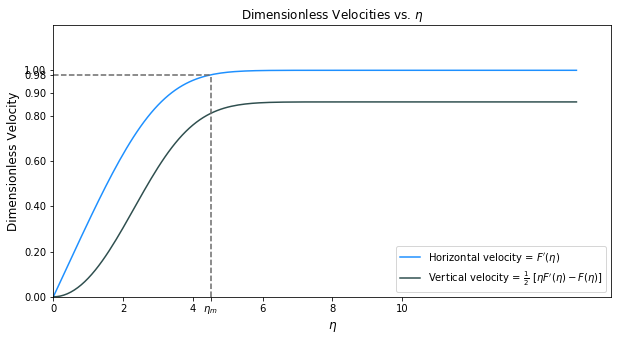

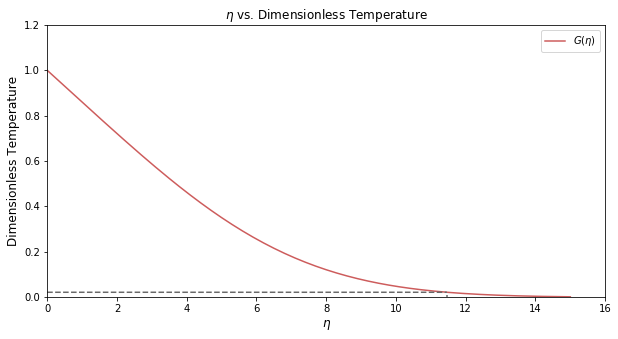

In [177]:
for idx, w in enumerate(W):
    F_prime = w[1][0]
    F = w[0][0]
    t = T[idx]
    v_curr = 0.5 * (t * F_prime - F)
    
    u.append(F_prime)
    eta.append(t)
    v.append(v_curr)
    G.append(w[3][0])

X_vert = []
Y_vert = []
for i in np.arange(0, 0.98, 0.01):
    Y_vert.append(i)
    X_vert.append(eta_m)
X_hor = []
Y_hor = []
for i in np.arange(0, eta_m, 0.01):
    X_hor.append(i)
    Y_hor.append(0.98)

plt.figure(figsize=(10,5))
plt.title(r"Dimensionless Velocities vs. $\eta$", fontsize=12)
plt.xlabel(r"$\eta$", fontsize=12)
plt.ylabel("Dimensionless Velocity", fontsize=12)
plt.xlim(0, tf+1)
plt.ylim(0, 1.2)
plt.xticks([0, 2, 4, eta_m, 6, 8, 10], ['0', '2', '4', r'$\eta_{m}$', '6', '8', '10'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.98, 1.0])
plt.plot(eta, u, color='dodgerblue', label=r"Horizontal velocity = $F^{\prime}(\eta)$")
plt.plot(eta, v, color='darkslategrey', label=r"Vertical velocity = $\frac{1}{2}\ [ \eta F^{\prime}(\eta) - F(\eta)]$")
plt.plot(X_vert, Y_vert, linestyle="dashed", color="dimgray", label="")
plt.plot(X_hor, Y_hor, linestyle="dashed", color="dimgray", label="")
plt.legend(loc='lower right')
# plt.savefig("../plate/img/velocities.PNG", dpi=200)
# plt.show()

X_vert = []
Y_vert = []
for i in np.arange(0, 0.02, 0.01):
    Y_vert.append(i)
    X_vert.append(eta_t)
X_hor = []
Y_hor = []
for i in np.arange(0, eta_t, 0.01):
    X_hor.append(i)
    Y_hor.append(0.02)

plt.figure(figsize=(10,5))
plt.title(r"$\eta$ vs. Dimensionless Temperature", fontsize=12)
plt.xlabel(r"$\eta$", fontsize=12)
plt.ylabel("Dimensionless Temperature", fontsize=12)
plt.xlim(0, tf+1)
plt.ylim(0, 1.2)
plt.plot(eta, G, color='indianred', label=r'$G(\eta)$')
plt.plot(X_vert, Y_vert, linestyle="dashed", color="dimgray", label="")
plt.plot(X_hor, Y_hor, linestyle="dashed", color="dimgray", label="")
plt.legend()
plt.show()

#### $\eta$ vs Temperature for different $Pr$

Done 0.1
Done 0.2
Done 0.5
Done 1
Done 2
Done 5
Done 10


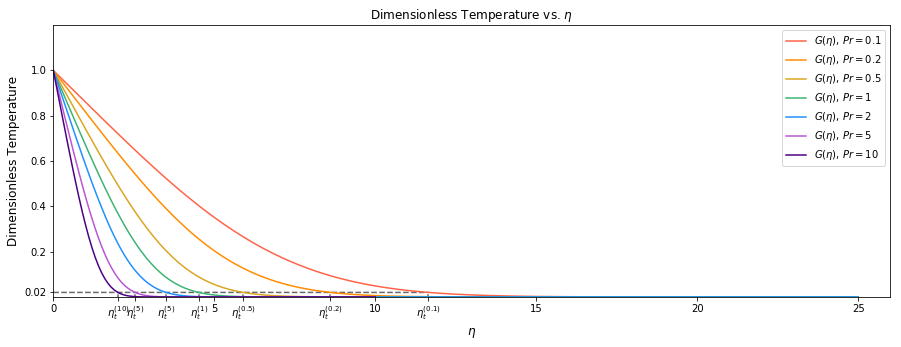

In [194]:
Prs = [0.1, 0.2, 0.5, 1, 2, 5, 10]
infinite = [25, 25, 25, 25, 25, 10, 10]
colors = ["tomato", "darkorange", "goldenrod", "mediumseagreen", "dodgerblue", "mediumorchid", "indigo"]

plt.figure(figsize=(15,5))
plt.title(r"Dimensionless Temperature vs. $\eta$", fontsize=12)
plt.xlabel(r"$\eta$", fontsize=12)
plt.ylabel("Dimensionless Temperature", fontsize=12)
plt.xlim(0, 26)
plt.ylim(0, 1.2)
xticks = [0, 5, 10, 15, 20, 25]
xlabels = ['0', r"$\eta_{t}^{(10)}$", r"$\eta_{t}^{(5)}$", r"$\eta_{t}^{(5)}$", r"$\eta_{t}^{(1)}$"]
xlabels += ['5', r"$\eta_{t}^{(0.5)}$", r"$\eta_{t}^{(0.2)}$", '10', r"$\eta_{t}^{(0.1)}$", '15', '20', '25']

for idx, p in enumerate(Prs):
    Pr = p
    W, T = solve_system(Pr=p, h=0.1, tol=10e-9, inf=infinite[idx])
    eta_t = get_eta_t(W)
    xticks.append(eta_t)

    G = []
    eta = []

    for idy, w in enumerate(W):
        eta.append(T[idy])
        G.append(w[3][0])
        
    X_vert = []
    Y_vert = []
    for i in np.arange(0, 0.02, 0.01):
        Y_vert.append(i)
        X_vert.append(eta_t)
    
    if p == 0.1:
        X_hor = []
        Y_hor = []
        for i in np.arange(0, eta_t, 0.01):
            X_hor.append(i)
            Y_hor.append(0.02)
        plt.plot(X_hor, Y_hor, linestyle="dashed", color="dimgray", label="")
        
    plt.plot(eta, G, color=colors[idx], label=r'$G(\eta)$, $Pr={}$'.format(p))
    plt.plot(X_vert, Y_vert, linestyle="solid", color="dimgray", label="")
    print("Done {}".format(p))

xticks = np.sort(xticks)
plt.xticks(xticks, xlabels)
plt.yticks([0.02, 0.2, 0.4, 0.6, 0.8, 1.0], ['0.02', '0.2', '0.4', '0.6', '0.8', '1.0'])
plt.legend()
plt.savefig("../plate/img/temperatures.PNG", dpi=200)
# plt.show()

#### $Pr$ vs $\eta$

In [204]:
Eta_t = []
infinite = [25, 25, 25, 25, 25, 10, 10]
for idx, p in enumerate(Prs):
    Pr = p
    W, T = solve_system(Pr=p, h=0.1, tol=10e-9, inf=infinite[idx])
    G = []
    eta = []
    for idx, w in enumerate(W):
        if w[3][0] >= 0.01 and w[3][0] <= 0.03:
            eta.append(T[idx])
            G.append(w[3][0])

    eta_t = lagrange_poly(G, eta, 0.02)
    Eta_t.append(eta_t)

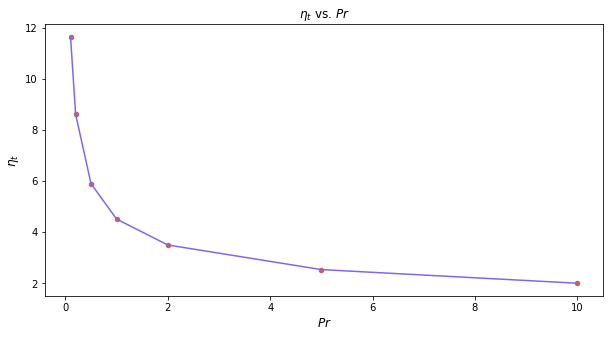

In [213]:
plt.figure(figsize=(10, 5))
plt.title(r"$\eta_{t}$ vs. $Pr$", fontsize=12)
plt.xlabel(r"$Pr$", fontsize=12)
plt.ylabel(r"$\eta_{t}$", fontsize=12)
plt.scatter(Prs, Eta_t, s=20, marker='o', color='indianred')
plt.plot(Prs, Eta_t, color='mediumslateblue')
# plt.show()
plt.savefig("../plate/img/eta-vs-Pr.PNG", dpi=200)

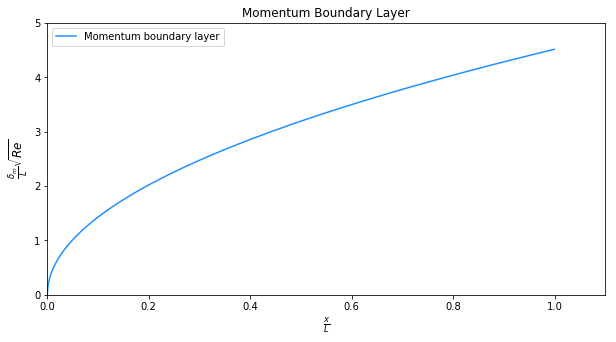

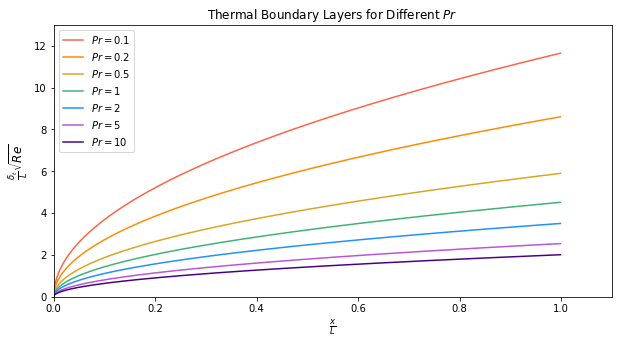

In [214]:
x = np.arange(0, 1, 0.001)
y = eta_m*np.sqrt(x)
plt.figure(figsize=(10,5))
plt.xlim(0, 1.1)
plt.ylim(0, 5)
plt.plot(x,y, color="dodgerblue", label="Momentum boundary layer")
plt.title("Momentum Boundary Layer", fontsize=12)
plt.xlabel(r"$\frac{x}{L}$", fontsize=12)
plt.ylabel(r"$\frac{\delta_m}{L}\sqrt{Re}$", fontsize=12)
plt.legend(loc='upper left')
# plt.show()
plt.savefig("../plate/img/momentum-BL.png", dpi=200)

plt.figure(figsize=(10,5))
plt.title(r"Thermal Boundary Layers for Different $Pr$", fontsize=12)
plt.xlabel(r"$\frac{x}{L}$", fontsize=12)
plt.ylabel(r"$\frac{\delta_t}{L}\sqrt{Re}$", fontsize=12)
plt.xlim(0, 1.1)
plt.ylim(0, 13)

for idx, eta_t in enumerate(Eta_t):
    
    X = np.arange(0, 1, 0.001)
    Y = eta_t*np.sqrt(X)
    plt.plot(X, Y, color=colors[idx], label=r"$Pr={}$".format(Prs[idx]))

plt.legend()
# plt.show()
plt.savefig("../plate/img/thermal-BL.png", dpi=200)